In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

# Import your custom modules
# If these fail, ensure the .py files are in the same folder as this notebook
from models.MST import MST_GNN
from dataset import InMemoryDynamicSP100
from models.train import train

# Setup Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

/home/alrodriguezg/U/s5/gnn/GNN_paper/code/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Device: cuda


In [2]:
# Data Configuration
PAST_WINDOW = 25       # Look-back window (Delta t)
FUTURE_WINDOW = 1      # Prediction horizon
BATCH_SIZE = 32

# MSCMG Graph Generation Params
RETURN_THRESH = 0.01   # 1% movement threshold
MAX_DIST = 5           # Max Manhattan distance for edges

# Model Configuration
INPUT_FEATURES = 9     # Check your values.csv (e.g., Open, Close, High, Low...)
HIDDEN_SIZE = 64
GRAPH_LAYERS = 2       # 'M' layers
CROSS_LAYERS = 2       # 'C' layers
LEARNING_RATE = 0.001

In [3]:
print("Initializing Dataset...")

# We set force_process=True ONLY if you changed the graph logic and need to regenerate.
# Otherwise set it to False to load from disk.
dataset = InMemoryDynamicSP100(
    root="./data", 
    past_window=PAST_WINDOW, 
    future_window=FUTURE_WINDOW,
    return_threshold=RETURN_THRESH,
    max_dist_threshold=MAX_DIST,
    force_process=False 
)

print(f"Total Samples: {len(dataset)}")
print(f"Feature Shape (Node, Time, Feat): {dataset[0].x.shape}")

Initializing Dataset...
Total Samples: 673
Feature Shape (Node, Time, Feat): torch.Size([100, 25, 10])


In [4]:
# Create a temporary loader to grab one batch
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
sample_batch = next(iter(loader))

print("--- Batch Inspection ---")
print(f"Batch Size (Graphs): {BATCH_SIZE}")
print(f"Total Nodes in Batch: {sample_batch.num_nodes}") 
print(f"Input Features (x):   {sample_batch.x.shape}")
print(f"Edge Index shape:     {sample_batch.edge_index.shape}")
print(f"Target Labels (y):    {sample_batch.y.shape}")

# Visualize the graph density of the first sample in the batch
num_nodes_sample = dataset[0].num_nodes
num_edges_sample = dataset[0].num_edges
print(f"\nSingle Graph Stats -> Nodes: {num_nodes_sample}, Edges: {num_edges_sample}")

--- Batch Inspection ---
Batch Size (Graphs): 32
Total Nodes in Batch: 3200
Input Features (x):   torch.Size([3200, 25, 10])
Edge Index shape:     torch.Size([2, 4488])
Target Labels (y):    torch.Size([3200])

Single Graph Stats -> Nodes: 100, Edges: 128


In [5]:
# 1. Get the actual feature count from the loaded dataset
# dataset[0].x is shape (Nodes, Time, Features) -> We want index 2
REAL_INPUT_FEATURES = dataset[0].x.shape[2] 
print(f"Dataset has {REAL_INPUT_FEATURES} features.")

# 2. Initialize Model with the CORRECT size
model = MST_GNN(
    in_features=REAL_INPUT_FEATURES, # <--- Use the dynamic value here!
    hidden_size=HIDDEN_SIZE,
    num_graph_layers=GRAPH_LAYERS,
    num_cross_layers=CROSS_LAYERS
).to(DEVICE)

print("Model initialized with correct input dimensions.")

Dataset has 10 features.
Model initialized with correct input dimensions.


In [6]:
model.eval() # Set to eval mode for testing
with torch.no_grad():
    # Move batch to device
    sample_batch = sample_batch.to(DEVICE)
    
    # Run Model
    logits = model(sample_batch.x, sample_batch.edge_index)
    
    print(f"Output Logits Shape: {logits.shape}")
    
    # Check shape: Should be (Total_Nodes_In_Batch, 1)
    assert logits.shape == (sample_batch.x.shape[0], 1), "Output shape mismatch!"
    print("✅ Forward pass successful!")

Output Logits Shape: torch.Size([3200, 1])
✅ Forward pass successful!


Starting Test Training (3 Epochs)...
Epoch 1 | Loss: 0.6956
Epoch 2 | Loss: 0.6923
Epoch 3 | Loss: 0.6921
✅ Training loop functional!


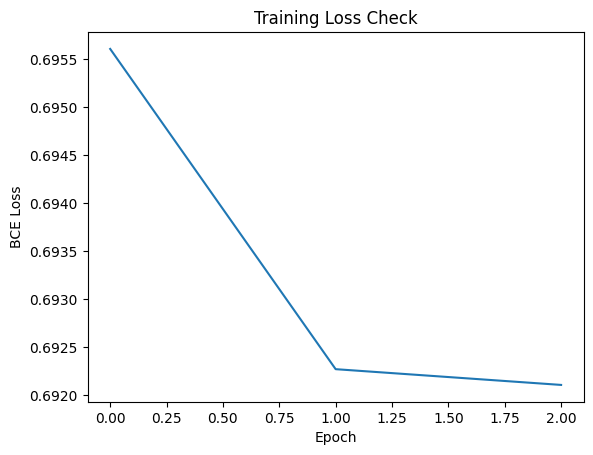

In [7]:
# Setup Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Split Train/Test (Simple split for testing)
train_size = int(0.8 * len(dataset))
train_set = dataset[:train_size]
test_set = dataset[train_size:]

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

print("Starting Test Training (3 Epochs)...")
model.train()

loss_history = []

for epoch in range(3):
    total_loss = 0
    steps = 0
    
    for batch in train_loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        
        # 1. Forward
        logits = model(batch.x, batch.edge_index)
        
        # 2. Labels: Convert continuous return to Binary (1 if > 0 else 0)
        # Ensure shape matches logits (N, 1)
        labels = (batch.y > 0).float().view(-1, 1)
        
        # 3. Backward
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        steps += 1
    
    avg_loss = total_loss / steps
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

print("✅ Training loop functional!")

# Plot Loss
plt.plot(loss_history)
plt.title("Training Loss Check")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.show()

In [8]:
# 1. Define Loss and Optimizer
# We use BCEWithLogitsLoss because the model outputs raw logits (no sigmoid in the last layer)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 2. Setup DataLoaders
# Split data: 80% Train, 20% Test
train_size = int(0.8 * len(dataset))
train_set = dataset[:train_size]
test_set = dataset[train_size:]

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training on {len(train_set)} samples, Testing on {len(test_set)} samples.")

# 3. Run the Training Loop
# Ensure you have the 'train' function defined from our previous step
train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    num_epochs=50,             # Adjust epochs as needed
    task_title="MST_GNN_Run_1",
    measure_acc=True
)

Training on 538 samples, Testing on 135 samples.


Epochs: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, Batch=100.0%]


In [9]:
torch.save(model.state_dict(), f"models/saved_models/UpDownTrend_MST_run1_{model.__class__.__name__}.pt")

Evaluating on 135 test samples...

             CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Down       0.48      0.02      0.04      6489
          Up       0.52      0.98      0.68      7011

    accuracy                           0.52     13500
   macro avg       0.50      0.50      0.36     13500
weighted avg       0.50      0.52      0.37     13500

Total Accuracy: 0.5184


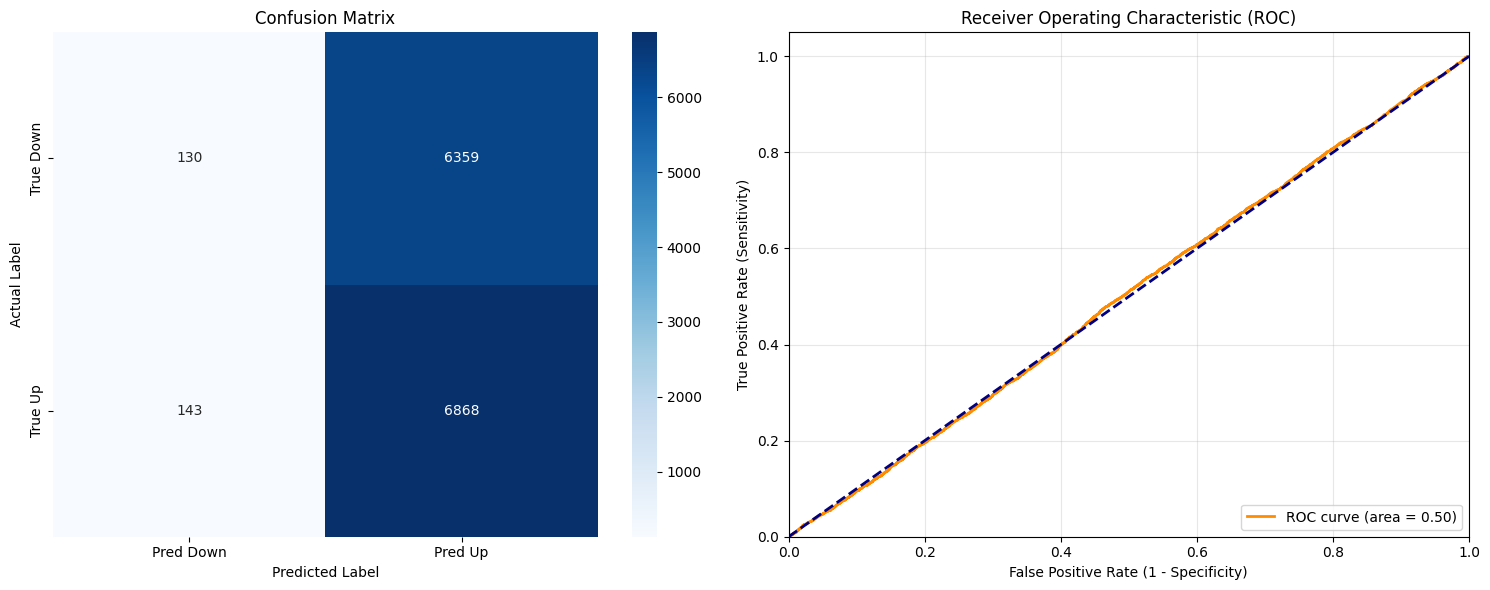

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from torch_geometric.loader import DataLoader

# --- 1. Setup Evaluation Data ---
# Re-create the test loader to ensure we are evaluating the correct split
# (Assumes 'dataset' is already loaded in memory from previous cells)
train_size = int(0.8 * len(dataset))
test_dataset = dataset[train_size:]
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Evaluating on {len(test_dataset)} test samples...")

# --- 2. Inference Function ---
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            # Move data to GPU
            data = data.to(DEVICE)
            
            # Forward pass (Using the 3-arg signature we fixed earlier)
            # data.edge_weight is passed but ignored by the model logic
            logits = model(data.x, data.edge_index, data.edge_weight)
            
            # Sigmoid to get probabilities (0.0 to 1.0)
            probs = torch.sigmoid(logits)
            
            # Threshold at 0.5 for binary class (0 or 1)
            preds = (probs > 0.5).float()
            
            # Process Labels (Continuous -> Binary)
            labels = (data.y > 0).float().view(-1, 1)
            
            # Store on CPU for plotting
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# --- 3. Run Inference ---
# If you want to load the specifically saved model file, uncomment the lines below:
model.load_state_dict(torch.load(f"models/saved_models/UpDownTrend_MST_run1_{model.__class__.__name__}.pt"))
model.to(DEVICE)

y_true, y_pred, y_prob = get_predictions(model, test_loader)

# --- 4. Visualizations ---

# A. Classification Report
print("\n" + "="*50)
print("             CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['Down', 'Up']))
print(f"Total Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# Setup Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# B. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Down', 'Pred Up'],
            yticklabels=['True Down', 'True Up'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

# C. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate (1 - Specificity)')
axes[1].set_ylabel('True Positive Rate (Sensitivity)')
axes[1].set_title('Receiver Operating Characteristic (ROC)')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()